In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant    
import scipy.stats as stats
import missingno as msno
from sklearn.ensemble import IsolationForest

dataset = pd.read_csv("sets/train.csv")
df = dataset.copy()

pd.set_option('display.float_format', '{:.2f}'.format)

# **Exploratory Data Analysis (EDA)**
## **1. Checklist de base**
## - Basic Exploration :
- ### Variable target :
  - Type : `df[target].dtypes` : int64
  - Distribution des classes : Vérifier si les classes sont déséquilibrées (classification) ou si la cible est bien répartie.
  - Résumé statistique : `df[target].describe()` :


In [8]:
print(df["trip_duration"].describe())

count   1458644.00
mean        959.49
std        5237.43
min           1.00
25%         397.00
50%         662.00
75%        1075.00
max     3526282.00
Name: trip_duration, dtype: float64


- ### Lignes et colonnes :
  - Nombre de lignes et de colonnes : `df.shape` : (1458644, 11)
  - Données uniques / redondantes : `df.columns.duplicated()` : aucune


In [3]:
print(df.shape)
print(df.columns.duplicated())

(1458644, 11)
[False False False False False False False False False False False]


- ### Types de variables :
  - Catégorielles : 2
  - Continues : 7
  - Dates / Temps : 2

In [69]:
print(df.info())
print(df['id'].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
0    id2875421
1    id2377394
2    id3858529
3    id3504673
4    id2181028
Name: id, dtype: object


- ### Analyse de valeurs manquantes (heatmap) :
  - Proportions par colonnes : aucune
  - Méthodes de gestion :     
    - Supression :     
    - Imputation :    


id                   0.00
vendor_id            0.00
pickup_datetime      0.00
dropoff_datetime     0.00
passenger_count      0.00
pickup_longitude     0.00
pickup_latitude      0.00
dropoff_longitude    0.00
dropoff_latitude     0.00
store_and_fwd_flag   0.00
trip_duration        0.00
dtype: float64


<Axes: >

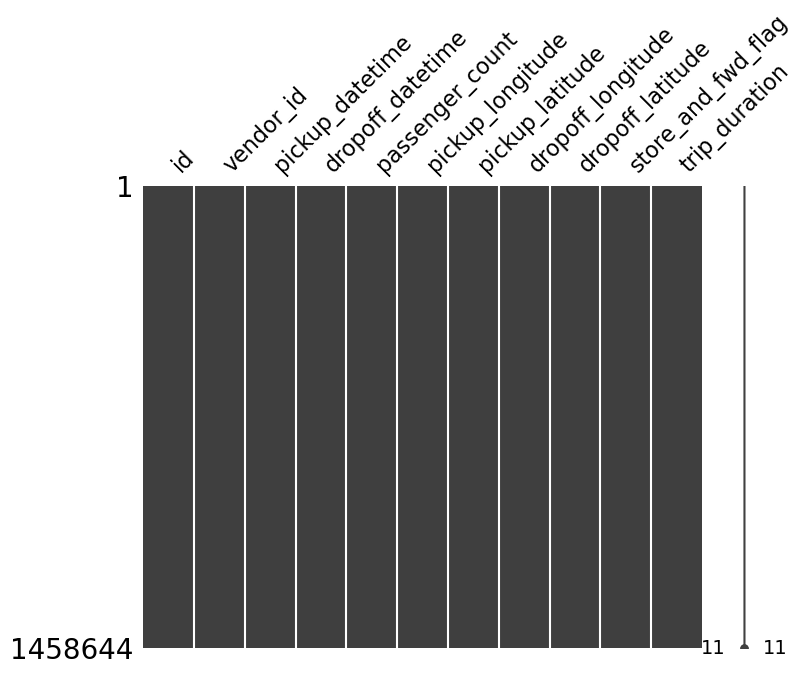

In [20]:
nan_value = df.isna().sum()/df.shape[0]
print(nan_value)
msno.matrix(df, figsize=(8, 6))

- ### Analyse des outliers (IQR, Z-score, boxplot) :
  - Proportions par colonnes (IQR) : 104113 
    - passenger_count :  0.033138997589542064
    - pickup_longitude :  0.00025160354411357395
    - pickup_latitude :  0.02300972684219042
    - dropoff_longitude :  0.001696095825986327
    - dropoff_latitude :  0.011858959417102459
    - trip_duration :  0.0014211829617096427
  - Observations : 
    - l'IQR détecte beaucoup d'ouliers, distributions asymétriques
    - beaucoup de Z-Score élevé (97459), ce qui indique des distributions asymétriques
    - l'IsolationForest ne détecte aucun outliers, dans ce cas, c'est cette métrique la plus fiable dû aux distributions asymétriques

  - Méthodes de gestion :
    - Supression : aucune
    - Imputation : aucune


In [66]:
continuous_features = df.select_dtypes(exclude="object").columns

def outliers_detection(df):
    # liste d'anomalies
    anomalies = []

    # Limite supérieur et inférieur à 3 écarts types
    data_std = statistics.stdev(df)
    data_mean = statistics.mean(df)
    anomaly_cut_off = data_std * 3

    lower_limit = data_mean - anomaly_cut_off
    upper_limit = data_mean + anomaly_cut_off

    # Génère les outliers
    for outlier in df:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    
    return anomalies

n_outliers = 0
for col in continuous_features:
    outliers = outliers_detection(df[col])
    print(f"{col} : {len(outliers)} : {len(outliers)/df.shape[0]}")
    n_outliers += len(outliers)

print(f"Nombres d'outliers : {n_outliers} ({n_outliers/df.shape[0]})")

vendor_id : 0 : 0.0
passenger_count : 48338 : 0.033138997589542064
pickup_longitude : 367 : 0.00025160354411357395
pickup_latitude : 33563 : 0.02300972684219042
dropoff_longitude : 2474 : 0.001696095825986327
dropoff_latitude : 17298 : 0.011858959417102459
trip_duration : 2073 : 0.0014211829617096427
Nombres d'outliers : 104113 (0.07137656618064449)


<Axes: >

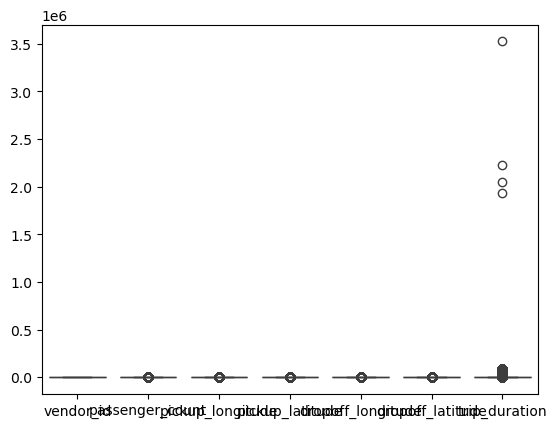

In [60]:
scaled_df = pd.DataFrame(MinMaxScaler().fit_transform(df[continuous_features]), columns=continuous_features)
sns.boxplot(df)

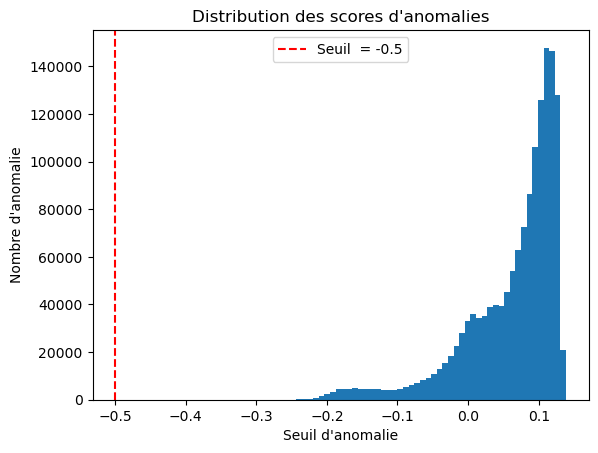

In [ ]:
model = IsolationForest(random_state=0, contamination='auto')
model.fit(scaled_df)
outliers_predict = model.predict(scaled_df) == -1
anomaly_score = model.decision_function(scaled_df)

plt.hist(anomaly_score, bins=50)
plt.axvline(x=-0.5, color="red", linestyle="--", label="Seuil  = -0.5")
plt.title("Distribution des scores d'anomalies")
plt.xlabel("Seuil d'anomalie")
plt.ylabel("Nombre d'anomalie")
plt.legend()

In [67]:
z_scores = stats.zscore(scaled_df)
outliers = df[(np.abs(z_scores) > 3).any(axis=1)]

print("Nombres d'outliers (z-score) : ", len(outliers))

Nombres d'outliers (z-score) :  97459




---


## - Data Cleaning :    
- ### Renommer les colonnes : `df.rename(function, axis=1, inplace=true)` : `col.replace(a, b)` :  

- ### Supprimer les colonnes inutiles :    

In [70]:
df = df.drop("id", axis=1)

- ### Fusionner les colonnes redondantes :    

- ### Convertir les types des colonnes :   

In [78]:
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

df = df.astype({col : "float32" for col in continuous_features})
print(df.dtypes.value_counts())

float32           7
datetime64[ns]    2
object            1
Name: count, dtype: int64


- ### Gérer les valeurs manquantes :

- ### Gérer les outliers :



---


## **2. Exploration Uni-variable**
- ### Variables Continues (histogram, boxplot, scatterplot):
  - Skewness (>0.5 ou <-0.5) : `(décalé)` :
  - Kurtosis (>5 ou ou <1) : `(forme applatie/pointue)` :
  - Variance :
  - Homoscedasticité :
  - Observation :

- ### Variables Catégorielles (barchat, countplot) :
  - Multiclasse :
  - Binaire :
  - Catégories dominantes :

## **3. Exploration Bi-variable**
- ### Variables Continues (scatterplot, matrice de corrélation) :
  - Observations :

- ### Variables Continue et Catégorielle (boxplot, violonplot, barplot, heatmap, cramer's-v, PMF, PDF, CDF) :
  - Observations :

- ### Variables Catégorielle (boxplot, violonplot, barplot, heatmap, cramer's-v, PMF, PDF, CDF) :
  - Observations :



---


## **4. Exploration Multi-variable**
- ### Variables Continues (scatterplot, matrice de corrélation) :
  - Observations :


- ### Variables Continue et Catégorielle (boxplot, violonplot, barplot, heatmap, cramer's-v, PMF, PDF, CDF) :
  - Observations :

- ### Variables Catégorielle (boxplot, violonplot, barplot, heatmap, cramer's-v, PMF, PDF, CDF) :
  - Observations :



---


## **5. Préparation des données pour la modélisation**
- ### Encodage :
  - ### Target :
  - ### Features :
- ### Transformation :
  - ### Feature Scaling :
  - ### Transformation Mathématique :
- ### Feature Engineering :